# Sensor Offsets
This notebook contains experiments used in determining the best way to work out sensor offsets in a dataset. See [Github Issue #268](https://github.com/BjerknesClimateDataCentre/QuinCe/issues/268).

## Setup
We use a peak detection algorithm described in this [StackOverflow question](https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135).

In [86]:
# Imports
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from math import floor
import sys

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


## Load data

In [87]:
# Load TSG
tsg = pd.read_csv('TSG.csv', names=['Time', 'SST'])

# Load GO and make UNIX time colum
go = pd.read_csv('GO.tsv', sep='\t')

go['UNIXTime'] = f'{go["PC Date"]} {go["PC Time"]}'

go['UNIXTime'] = go.apply(
    lambda row:
        int(datetime.timestamp(
            datetime.strptime(f'{getattr(row, "PC Date")} {getattr(row, "PC Time")}', '%d/%m/%y %H:%M:%S'))),
        axis=1)

min_time = min(tsg['Time'])
if min(go['UNIXTime']) < min_time:
    min_time = min(go['UNIXTime'])
    
max_time = max(tsg['Time'])
if max(go['UNIXTime']) > max_time:
    max_time = max(go['UNIXTime'])

print(f'Minimum time: {min_time}')
print(f'Maximum time: {max_time}')

Minimum time: 1543618976
Maximum time: 1558556342


## Set Time Range

In [104]:
time_start = 1545000000
time_end = 1545172800

#time_start = 1543618976
#time_end = 1558556342

tsg_filtered = tsg.loc[(tsg['Time'] >= time_start) & (tsg['Time'] <= time_end)]
go_filtered = go.loc[(go['UNIXTime'] >= time_start) & (go['UNIXTime'] <= time_end)]

print(f'Select {len(tsg_filtered)}/{len(go_filtered)} values')

Select 17271/1150 values


## SST from TSG and EqT from GO

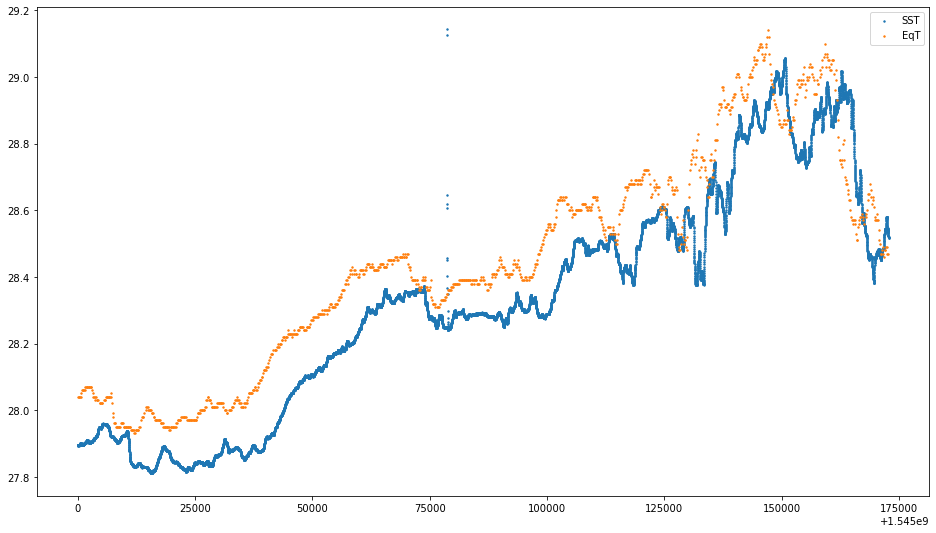

In [105]:
plt.figure(figsize=(16, 9))
plt.scatter(tsg_filtered['Time'], tsg_filtered['SST'], label='SST', s=2)
plt.scatter(go_filtered['UNIXTime'], go_filtered['equ temp'], label='EqT', s=2)
plt.legend()

## Set up peak detector
Set the parameters for the peak detection algorithm

|Parameter |Meaning                                                                        |
|----------|-------------------------------------------------------------------------------|
|lag       |The number of values to use in the moving average.                             |
|threshold |Signal threshold (in standard deviations from the moving average).             |
|influence |The influence of a signal as a fraction of the influence of normal data points.|

Because the two time series have different sampling rates, our lag is defined as a period of time, which is then converted to a number of measurements based on the mean spacing between measurements across each time series. For example, using our complete TSG dataset:

1. Target lag window: 1 day (86,400 seconds)
2. Number of measurements in TSG data set: 918,537
3. TSG measurement range: 2018-11-30 23:02:56 to 2019-05-22 20:19:02 (14,937,366 seconds)
4. Seconds per measurement: $\frac{14937366}{918537} = 16.26$ measurements per second
5. Lag size = $floor\left(\frac{86400}{16.26}\right) = 5313$ measurements

*Note that we assume that our measurements are regularly spaced. This is a good enough approximation for our needs.*

In [112]:
# Peak detector settings
DEFAULT_LAG_WINDOW = 172800
THRESHOLD=3
INFLUENCE=0.5

def calc_lag(times):
    value_count = len(times)
    time_range = times[len(times) - 1] - times[0]
    seconds_per_measurement = time_range / value_count
    
    lag_window = DEFAULT_LAG_WINDOW
    lag_size = floor(lag_window / seconds_per_measurement)
    while lag_size >= len(times):
        lag_window = floor(lag_window / 2)
        lag_size = floor(lag_window / seconds_per_measurement)
    
    return lag_size

## Run peak detector for SST and EqT

In [113]:
sst_lag_size = calc_lag(list(tsg_filtered['Time']))
print(sst_lag_size)
sst = list(tsg_filtered['SST'])
sst_peaks = thresholding_algo(sst, sst_lag_size, THRESHOLD, INFLUENCE)

eqt_lag_size = calc_lag(list(go_filtered['UNIXTime']))
print(eqt_lag_size)
eqt = list(go_filtered['equ temp'])
eqt_peaks = thresholding_algo(eqt, eqt_lag_size, THRESHOLD, INFLUENCE)

8635
575


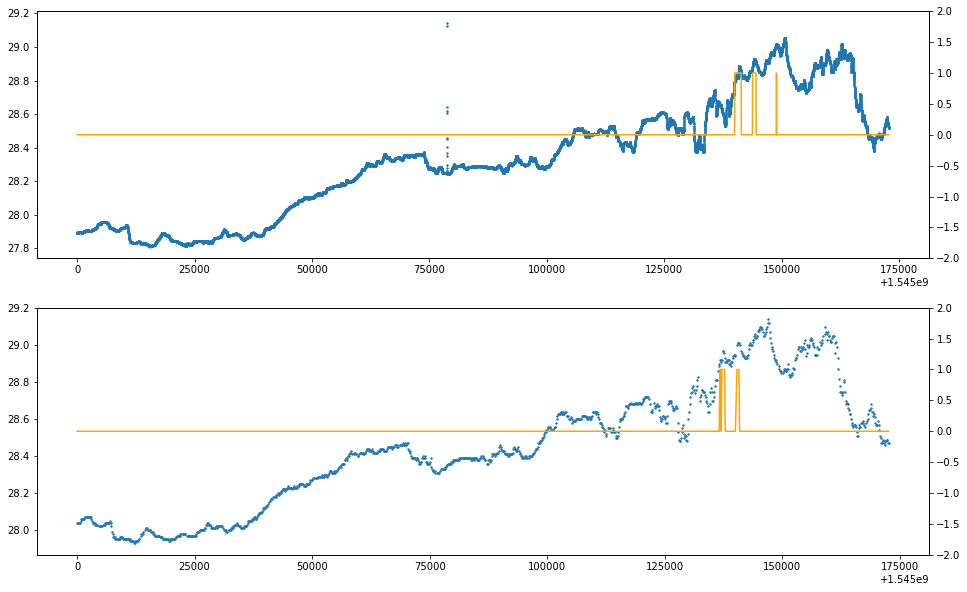

In [114]:
fig, (sst_ax, eqt_ax) = plt.subplots(2, figsize=(16, 10))

sst_ax.scatter(tsg_filtered['Time'], tsg_filtered['SST'], label='SST', s=2)
sst_ax2 = sst_ax.twinx()
sst_ax2.set_ylim(-2,2)
sst_ax2.plot(tsg_filtered['Time'], sst_peaks['signals'], color="orange")

eqt_ax.scatter(go_filtered['UNIXTime'], go_filtered['equ temp'], label='EqT', s=2)
eqt_ax2 = eqt_ax.twinx()
eqt_ax2.set_ylim(-2,2)
eqt_ax2.plot(go_filtered['UNIXTime'], eqt_peaks['signals'], color="orange")

## Extract peak positions
Find the places in each time series where the peaks series goes from zero to one (or -1). We exclude periods where the source time series contains NaNs **(not yet implemented)**.

In [52]:
def get_peak_positions(times, peaks):
    peak_positions = list()
    
    last_value = peaks[0]
    
    for i in range(1, len(peaks)):
        if peaks[i] != 0:
            if last_value == 0:
                peak_positions.append(times[i])
    
        last_value = peaks[i]
        
    return peak_positions

sst_peak_positions = get_peak_positions(list(tsg_filtered['Time']), sst_peaks['signals'])
eqt_peak_positions = get_peak_positions(list(go_filtered['UNIXTime']), eqt_peaks['signals'])

print(f'SST peak count: {len(sst_peak_positions)}')
print(f'EqT peak count: {len(eqt_peak_positions)}')

SST peak count: 5
EqT peak count: 2


## Calculate offsets
The number of offsets has to be based on the series with the fewest peaks. For each of these we find the peak in the other series that is closest to it, and calculate the offset between the two.

Since series being offset is not necessarily the shortest, which way the offsets are calculated is an independent assessment. In the function below we change entries in  `adjust_list` to align with `base_list`, so we adjust EqT to SST by calling `make_offsets(sst_peak_positions, eqt_peak_positions)`. We also know that EqT comes after SST in the physical flow of the instrument, so all adjustments to `adjust_list` have to be negative (backwards in time). We can also apply a limit to prevent excessive adjustments being made.

We loop through the `adjust_list`, and find the closest value from the `base_list` that is before the `adjust` value (and within the limit). If there is one, we record that as the adjustment and go to the next. If any two `adjust` values try to adjust to the same `base` value, we only accept the first one to ensure that regions of the `adjust` time series don't collapse into a black hole type situation.

# We are currently stuck on the fact that SST seems to be lagging behind EqT in this data. This shouldn't be possible, right?

In [85]:
def make_offsets(base_list, adjust_list, max_difference=600):

    
    
    
    base_pos = 0
    base_pos_used = False
    
    for adjust_pos in range(0, len(adjust_list)):
        print(adjust_pos)
    
    return 'tt'

eqt_offsets = make_offsets(sst_peak_positions, eqt_peak_positions, max_difference=600)
print(eqt_offsets)

0
1
tt
